In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

Let's start tackling the problem of many types of particles, and modifiying the functions from the 1 type.

To define diagram with n types of particle, we will still use the same points array as the 1 type case, but now there will be n arrays for the paths, so as a example in the case of quarks, antiquarks and gluons a simple diagram could be.

In [42]:
points =  np.array([[0, -1], [0, 1], [1, 0], [2, 0]])
paths_q = np.array([[1, 3]])
paths_a = np.array([[2, 3]])
paths_g = np.array([[3, 4]])

But this way of separating the paths is inconvenient for the function that we define, so instead let's add them in a single array

In [43]:
def combine_paths(*paths):
    max_len = max([len(path) for path in paths])
    final_path = np.zeros((len(paths), max_len, 2), dtype=int)
    for i in range(len(paths)):
        if len(paths[i]) < max_len:
            final_path[i] = np.append(paths[i], np.zeros((max_len - len(paths[i]), 2), dtype=int), axis=0)
        else:
            final_path[i] = paths[i]
    return final_path
        
paths = combine_paths(paths_q, paths_a, paths_g)

In [44]:
def find_equal_subarrays(array):
    sorted_subarrays = [np.sort(subarray) for subarray in array]
    unique_subarrays, indices, counts = np.unique(sorted_subarrays, axis=0, return_index=True, return_counts=True)
    duplicate_positions = [np.where((sorted_subarrays == unique_subarrays[i]).all(axis=1))[0] for i in range(len(unique_subarrays)) if counts[i] > 1]
    return duplicate_positions

def represent_diagram (points, all_paths, index = False, directory = "", colors = ["tab:blue", "tab:red", "black"], line = ["solid", "solid", "dashed"]):
    fig=plt.figure(figsize=(5,3)) 
    ax=fig.add_subplot(111)
    ax.axis('off')
    j = 0
    for paths in all_paths:
        loops = find_equal_subarrays(paths)
        for i in range(len(paths)):
            if (line[j] == "dashed"):
                with mpl.rc_context({'path.sketch': (3, 15, 1)}):
                    if np.isin(i, loops):
                        middle_point = (points[paths[i, 0]-1] + points[paths[i, 1]-1]) / 2
                        circle = plt.Circle((middle_point[0], middle_point[1]), np.linalg.norm(points[paths[i, 0]-1]-middle_point), color=colors[j], fill=False)
                        ax.add_patch(circle)
                    else:
                        ax.plot([points[paths[i, 0]-1, 0], points[paths[i, 1]-1, 0]], [points[paths[i, 0]-1, 1], points[paths[i, 1]-1, 1]], color=colors[j])
            else:
                if np.isin(i, loops):
                    middle_point = (points[paths[i, 0]-1] + points[paths[i, 1]-1]) / 2
                    circle = plt.Circle((middle_point[0], middle_point[1]), np.linalg.norm(points[paths[i, 0]-1]-middle_point), color=colors[j], fill=False, linestyle=line[j])
                    ax.add_patch(circle)
                else:
                    ax.plot([points[paths[i, 0]-1, 0], points[paths[i, 1]-1, 0]], [points[paths[i, 0]-1, 1], points[paths[i, 1]-1, 1]], color=colors[j], linestyle=line[j])
        j+=1
    if index:
        for i in range(len(points)):
            ax.text(points[i, 0], points[i, 1], str(i+1), fontsize=12, color="black", ha="right", va="top")
    if directory != "":
        plt.savefig(directory, bbox_inches='tight')
        plt.close()

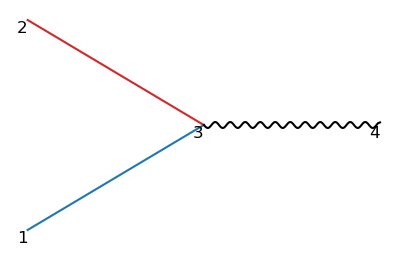

In [45]:
represent_diagram(points, paths, index=True)

In [46]:
def unique_values(array):
    unique, counts = np.unique(array, return_counts=True)
    unique_values = unique[counts == 1]
    return unique_values

print(unique_values(paths.flatten()))

[1 2 4]


In [47]:
def trim_zeros_2D(array, axis=1):
    mask = ~(array==0).all(axis=axis)
    inv_mask = mask[::-1]
    start_idx = np.argmax(mask == True)
    end_idx = len(inv_mask) - np.argmax(inv_mask == True)
    if axis:
        return array[start_idx:end_idx,:]
    else:
        return array[:, start_idx:end_idx]
    
def trim_zeros_3D(array):
    # Create a mask to identify non-zero elements along each dimension
    mask = ~(array == 0).all(axis=(1, 2))
    trimmed_array = array[mask]
    
    mask = ~(trimmed_array == 0).all(axis=(0, 2))
    trimmed_array = trimmed_array[:, mask]
    
    mask = ~(trimmed_array == 0).all(axis=(0, 1))
    trimmed_array = trimmed_array[:, :, mask]
    
    return trimmed_array

def in_out_paths (paths):
    max_len = max([len(path) for path in paths])
    #len(paths) is the number of type of particles
    in_out_paths = np.zeros((len(paths), 2, max_len), dtype=int)
    unique_vals = unique_values(paths.flatten())
    for i in range(len(paths)):
        inp = 0
        out = 0
        for j in range(max_len):
            if paths[i, j, 0] in unique_vals:
                in_out_paths[i, 0, inp] = paths[i, j, 0]
                inp += 1
            if paths[i, j, 1] in unique_vals:
                in_out_paths[i, 1, out] = paths[i, j, 1]
                out += 1
    return in_out_paths

In [48]:
print(in_out_paths(paths))

[[[1]
  [0]]

 [[2]
  [0]]

 [[0]
  [4]]]


In the case of multiple types of particles, to connect the different points, there will be some differences compared to the 1 type case. 

Since now the paths are arrays with one more dimension, this need to be taken account.

In [ ]:
def connection (points1, paths1, points2, paths2, offset = 0):
    in_out_paths1 = in_out_paths(paths1)
    in_out_paths2 = in_out_paths(paths2)

    #Create the new points array
    points = np.zeros((len(points1) + len(points2), 2))
    points[:len(points1)] = points1
    points[len(points1):] = points2 + np.array([np.max(points1)+1, offset])

    #Displace the paths of the second diagram to rename the points
    for i in range(len(in_out_paths2)):
        for j in range(len(in_out_paths2[0])):
            for k in range(len(in_out_paths2[0, 0])):
                if in_out_paths2[i, j, k] != 0:
                    in_out_paths2[i, j, k] += len(points1)

    n1 = np.zeros(len(in_out_paths1))
    n2 = np.zeros(len(in_out_paths2))
    max_connections = np.zeros(len(in_out_paths2))
    for i in range(len(in_out_paths1)):
        n1[i] = len(np.trim_zeros(in_out_paths1[i, 0]))
        n2[i] = len(np.trim_zeros(in_out_paths2[i, 1]))
    for i in range(len(in_out_paths1)):
        max_connections[i] = min(n1[i], n2[i])

    n_connections = 0

        

In [50]:
connection(points, paths, points, paths)

[0. 0. 0.]
